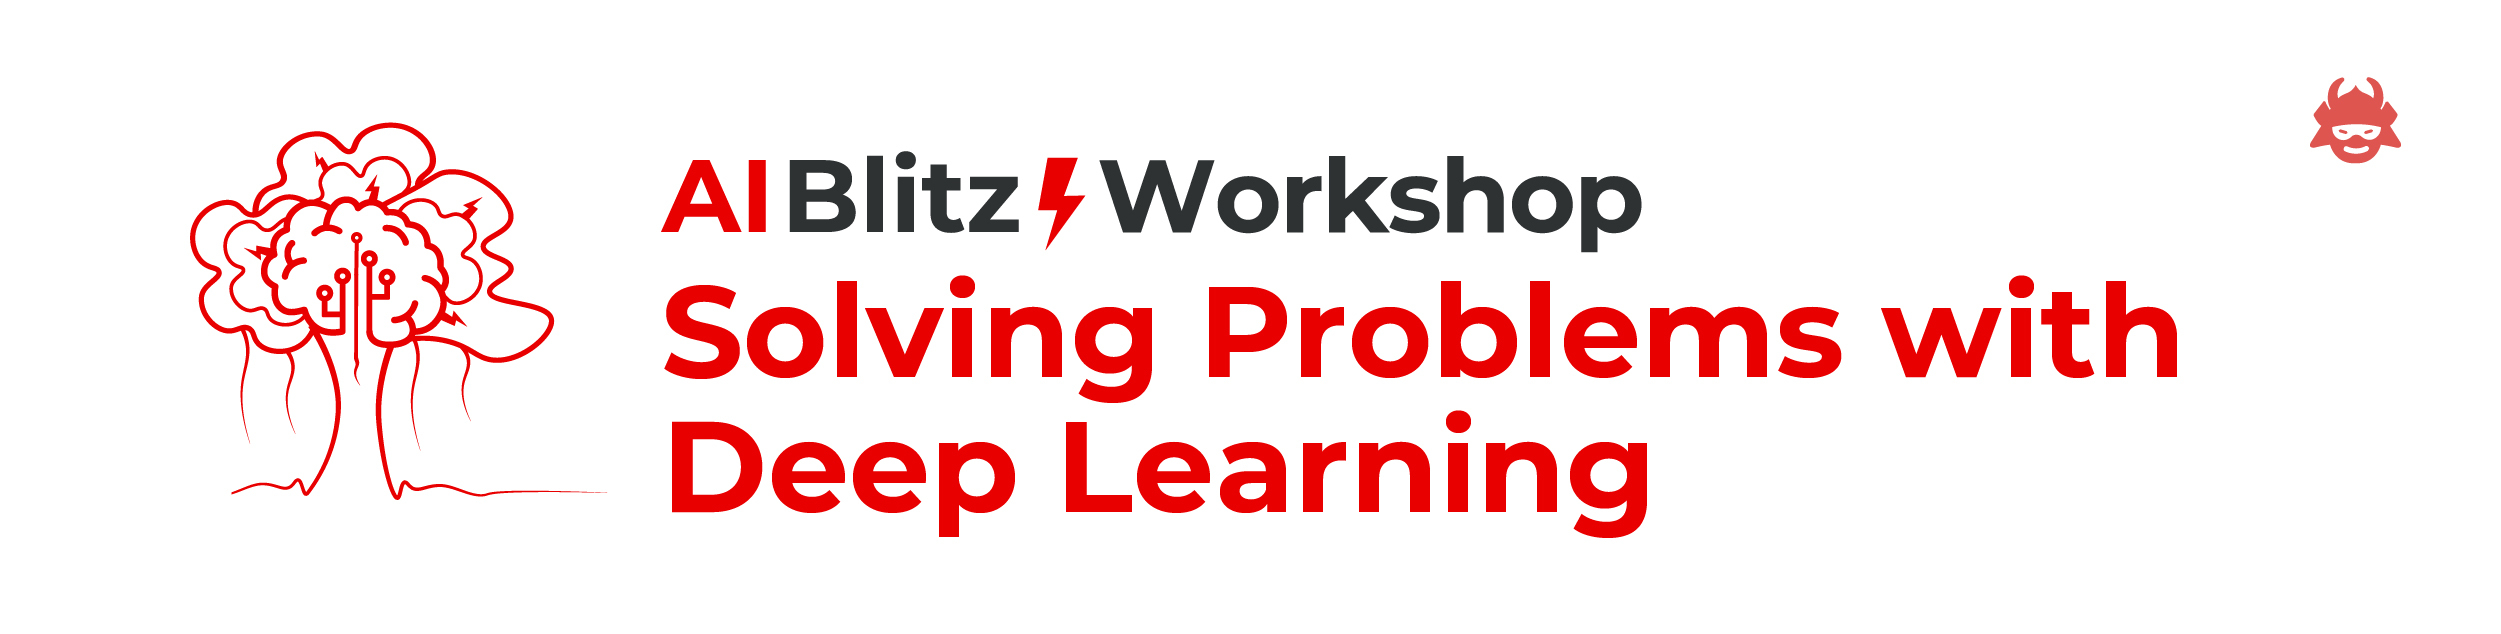

# Getting Started Code for [Debris Detection Puzzle](//www.aicrowd.com/challenges/debris-detection) on AIcrowd

---

## What is Object Detection?

Object detection is a computer technology related to computer vision and image processing that deals with detecting the existance of certain objects in images as well as videos. Well-researched domains of object detection include face detection and pedestrian detection.

---

## Download Necessary Packages 📚

`pyyaml` is a YAML parser and emitter for Python. Thus we will be installing it. 


We will also be installing the `aicrowd-cli` which would be used for accessing the datasets and making our submissions to the problems to see how we performed.

`pytorch` will be used for it's Deep Learning functions and capabilities. 
It is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. 

In [ ]:

!pip install -U aicrowd-cli


# Let's download pyyaml and update PyTorch!
!pip install pyyaml==5.1
!pip install torch==1.7.1 torchvision==0.8.2

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

# Installing Detectron2
import torch
assert torch.__version__.startswith("1.7")   
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

## Download Data ⏬
The first step is to download out train test data. We will be training a model on the train data and make predictions on test data. We submit our predictions.

Please enter your API Key from https://www.aicrowd.com/participants/me




In [ ]:
API_KEY = "YOUR_API_KEY" 
!aicrowd login --api-key $API_KEY

Using the piece of code below, we will be downloading our dataset or problem that we would like to solve.

In [ ]:
!aicrowd dataset download --challenge debris-detection

It's time to make some new directories, unzip zip files and move files around.

In [ ]:
# Removing any folder named "data"a
!rm -rf data

# Creating a folder named "data"
!mkdir data

# Unziping train.zip
!unzip train.zip -d data/train > /dev/null

# Unziping val.zip
!unzip val.zip -d data/val > /dev/null

# Unziping test.zip
!unzip test.zip -d data/test > /dev/null

# Moving train.csv and val.csv to the "data" folder
!mv train.csv data/train.csv
!mv val.csv data/val.csv

## Import packages 📦

---


**What's Detectron2?** 🔍

Detectron is Facebook AI Research’s (FAIR) software system that implements state-of-the-art **object detection algorithms**, including Mask R-CNN. It is written in Python.
Detectron 2 is a complete rewrite of the first Detectron which was released in the year 2018.

Detectron 2 comes to the rescue if we want to train an object detection model in a snap with a custom dataset. All the models present in the model zoo of the Detectron 2 library are pre-trained on COCO Dataset. We just need to fine-tune our custom dataset on the pre-trained model.



---

**Pandas, Numpy and MatplotLib** 🏃🏽‍♂️

Pandas is a very well known library used specifically with Tabular and move rows/columns around or do data manipulation. 

Numpy is another libarary filled with math functions and ability to help us play with data structures. 

Matplotlib may or may not sound new to you. It is a library used for producing graphs, charts and images!

---

In [ ]:
# Importing PyTorch below!

import torch, torchvision


# Importing Detectron and other requirements from it

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode


# Other libraries for dealing with the data!

import pandas as pd
import numpy as np

import os

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2

from tqdm.notebook import tqdm
import random
from ast import literal_eval

## Load Data
- We use pandas 🐼 library to load our data.   
- Pandas loads the data into dataframes and facilitates us to analyse the data.   
- Learn more about it [here](https://www.tutorialspoint.com/python_data_science/python_pandas.htm) 🤓

In [ ]:
# Defining the path where everything is stored on my runtime
data_path = "data"

# Reading the train.csv and val.csv as DataFrames
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
val_df = pd.read_csv(os.path.join(data_path, "val.csv"))

## Visualize the data 👀

The given dataset contains images of space with space debris. The images are of size 256*256 in jpg format. The bounding boxes are in bboxes with the columns as ImageId and bboxes0  containing list in [xmin, xmax, ymin, ymax] format.

In [ ]:
train_df

`show_images` is a function that we will be defining. This function will help us show images with bounding boxes around the objects that we want to detect!

In [ ]:
def show_images(images, num = 5):
    
    # "images_to_show" basically chooses the "num" number choices from the list given to it:
    images_to_show = np.random.choice(images, num)

    # You know what? Let's open every picture one by one!
    for image_id in images_to_show:

        # Openining the image from it's path:
        image = Image.open(os.path.join(data_path, f"train/{image_id}.jpg"))

        # Finding the list of coordinates for it's bounding boxes:
        bboxes = literal_eval(train_df.loc[train_df['ImageID'] == image_id]['bboxes'].values[0])

        # Drawing the bounding boxes on the image 🏃🏽‍♀️:
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:   
            draw.rectangle([bbox[0], bbox[2], bbox[1], bbox[3]], width=1)

        # Now, we will finally use MatplotLib for producing the image:
        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()

show_images(train_df['ImageID'].unique(), num = 5)

# Creating Dataset

In Detectron and PyTorch libraries we need to create custom functions to facilitate the creation of datasets.


In [ ]:


dict_dataset = []
def get_dataset_dics():

    # Grabbing the index and row in our Training DataFrame!
    for index, row in train_df.iterrows():
        
        # Grabbing the image:
        image = Image.open(os.path.join(data_path, f"train/{row['ImageID']}.jpg"))

        # The width and height of our Image:
        w, h = image.size
        
        ann_lst = []

        bboxes = literal_eval(row['bboxes'])

        # Grabbing the coordinates of the boxes:
        for n, bbox in enumerate(bboxes):   

            # Creating a Python Dictionary for our annotations:
            ann_dict = {'bbox': [bbox[0], bbox[2], bbox[1], bbox[3]],
           'bbox_mode': BoxMode.XYXY_ABS,
           'category_id': 0, #i[1]['category_id'].values[0],
           'iscrowd': 0}
            
            # Appending our dictionary to the empty list we mentioned above:
            ann_lst.append(ann_dict)

        # Prodicing our final Dictionary:
        image_dict = {'annotations': ann_lst,
            'file_name': os.path.join(data_path, f"train/{row['ImageID']}.jpg"),
            'height': h,
            'image_id': row["ImageID"], #i[1]['image_category_id'].values[0],
            'width': w}
        # Appending that dictionary
        dict_dataset.append(image_dict)

    return dict_dataset

# Calling the function as dict_dataset:
dict_dataset = get_dataset_dics()

In [ ]:
d = f"debris_train{np.random.randint(10000)}"

# Registering our newly created dataset function into the DatasetCatalog!
DatasetCatalog.register(d, lambda d=d : get_dataset_dics())

# Defining the classes:
MetadataCatalog.get(d).set(thing_classes=["Debris"])

# Grabbing everything and going ahead with it:
obj_metadata = MetadataCatalog.get(d)

Since our dataset function has been defined, now it is time to use it for putting out some bounding boxes on our images.

In [ ]:
for i in random.sample(dict_dataset, 3):
    img = cv2.imread(i["file_name"])
    visualizer = Visualizer(img, metadata=obj_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(i)
    plt.imshow(out.get_image())

# Creating the Model

### How does the R-CNN work?

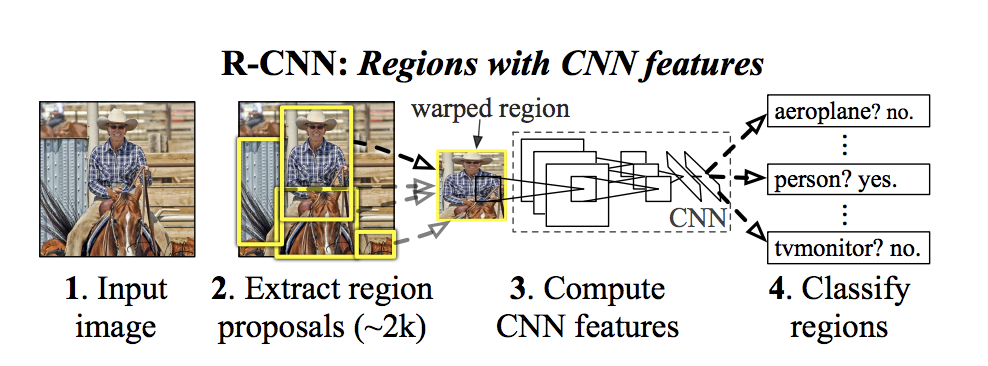

### Now how does the Fast R-CNN algorithm work?
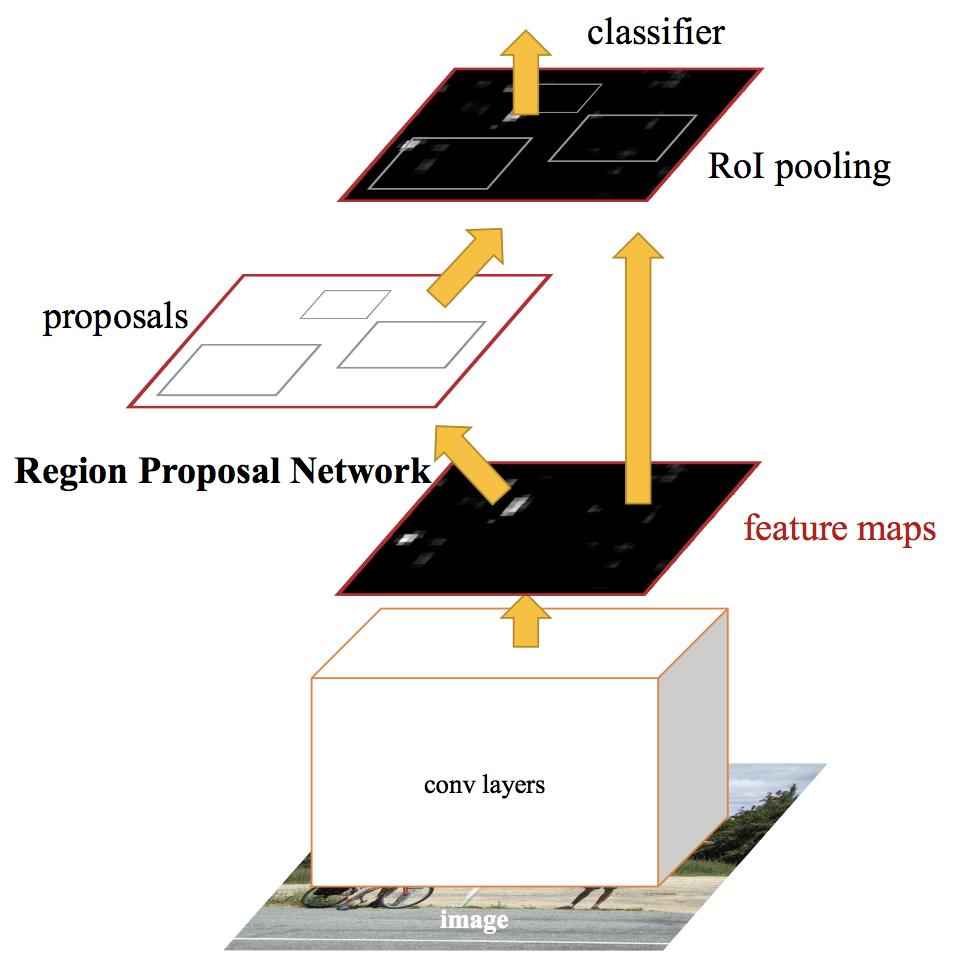

In [ ]:
# Using the "get_cfg()" function to the get the configurations:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml"))

# Grabbing our Dataset:
cfg.DATASETS.TRAIN = (d,)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2

# Loading our Model's weights:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml") 

# Defining the Hyperparameters:
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 200
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Making a seperate output folder:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## Train the Model 🚀🚀

Finally! All the hardwork, now it's time to train the model.

In [ ]:

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Testing Phase 😅

We are almost done. We trained and validated on the training data. Now its the time to predict on test set and make a submission.# Prediction on Evaluation Set

## Loading Pretrained Model

Now since we have trained and saved our model, it's time we take it out to test it on the test dataset.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

## Predict Test Set 👀
Predict on the test set and you are all set to make the submission!

In [ ]:
test_imgs_paths = os.listdir(os.path.join(data_path, "test"))

predictions = {"ImageID":[], "bboxes":[]}

for test_img_path in tqdm(test_imgs_paths):

  img = cv2.imread(os.path.join(data_path, "test", test_img_path))
  h, w, _ = img.shape

  model_predictions = predictor(img)

  bboxes = model_predictions['instances'].pred_boxes.tensor.cpu().numpy().tolist()
  scores = model_predictions['instances'].scores.cpu().numpy().tolist()

  for n, bbox in enumerate(bboxes):

      bboxes[n] == bbox.append(scores[n])

  image_id = test_img_path.split('.')[0]

  predictions['ImageID'].append(image_id)
  predictions['bboxes'].append(bboxes)

## Save the prediction to csv

In [ ]:
submission = pd.DataFrame(predictions)
submission

In [ ]:
submission.to_csv("submission.csv", index=False)

## Making Direct Submission 

In [ ]:
!aicrowd submission create -c debris-detection -f submission.csv